## First of All...

If you are using this notebook from Google Colab, you need to fetch the necessary resources by running:

In [ ]:
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab03/resources.tgz
!tar -xzf resources.tgz
!pip install pillow
!pip install prince
!pip install fastdtw
!pip install pyproj

In [4]:
%matplotlib inline

#
# REQUIRED FOR THIS NOTEBOOK:
# pip3 install prince
#

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from datetime import datetime

# Read data
data = pd.read_csv('resources/ks-projects-201801.csv')
# Focus on a specific main category
data = data[data['main_category'] == 'Design']
# Random subsampling
np.random.seed(42)
idx = np.random.choice(np.arange(len(data)), 2000, replace=False)
data = data.iloc[idx]
# Compute campaing duration
data['launched'] = pd.to_datetime(data['launched'])
data['deadline'] = pd.to_datetime(data['deadline'])
data['duration'] = (data['deadline'] - data['launched']).dt.days
# Compute success state
data['success'] = (data['state'] == 'successful').astype(float)
# Select a subset of the columns
data = data[['name', 'category', 'usd_goal_real', 'duration', 'success']]
# Category as... a category
data['category'] = data['category'].astype('category')
data.head()

,name,category,usd_goal_real,duration,success
154905,Tactical Laser Tag Arena,Architecture,50000.00,34,0.0
205034,Soak & Go shower head cleaning cup,Product Design,21000.00,30,0.0
129412,"Create your own high quality Revolo, unique an...",Product Design,27884.98,29,1.0
372633,Tundra Title Belt,Product Design,1200.00,59,0.0
263539,The Most Tactical Baby Carrier and Diaper Pack...,Product Design,30000.00,34,0.0


In [5]:
# Apply MCA to categorical data
import prince

mca = prince.MCA(n_components=2)
Xcat = mca.fit_transform(data[['category']])

In [6]:
# Obtain a combined dataset
Xreal = data[['usd_goal_real', 'duration']]
X = np.hstack([Xreal, Xcat])
X.shape

(2000, 4)

In [7]:
# Scale all data
scaler = StandardScaler()
X = scaler.fit_transform(X)

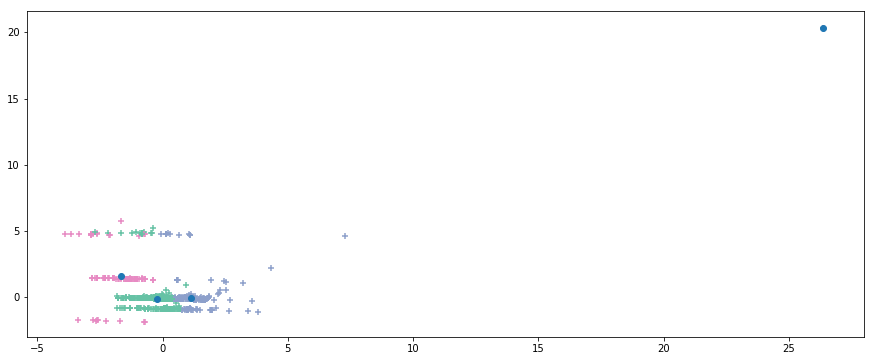

CLUSTER 0 (1396 items)
usd_goal_real    22705.863159
duration            29.146132
success              0.367479
dtype: float64
Architecture          0.027221
Civic Design          0.000000
Design                0.155444
Graphic Design        0.000000
Interactive Design    0.013610
Product Design        0.803725
Typography            0.000000
dtype: float64
CLUSTER 1 (1 items)
usd_goal_real    22327409.13
duration               59.00
success                 0.00
dtype: float64
Architecture          1.0
Civic Design          0.0
Design                0.0
Graphic Design        0.0
Interactive Design    0.0
Product Design        0.0
Typography            0.0
dtype: float64
CLUSTER 2 (460 items)
usd_goal_real    60105.434652
duration            49.980435
success              0.315217
dtype: float64
Architecture          0.043478
Civic Design          0.000000
Design                0.150000
Graphic Design        0.021739
Interactive Design    0.021739
Product Design        0.763043
Typograp

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Build a clustering object
cls = KMeans(4)
# Train
cls.fit(X)
# Find cluster for each data point
y = cls.labels_

# Dimensionality reduction to allow visualization
pca = PCA(2)
Xred = pca.fit_transform(X)
Cred = pca.transform(cls.cluster_centers_)

# Display results (scatter)
plt.figure(figsize=(15, 6))
plt.scatter(Xred[:, 0], Xred[:, 1], marker='+', c=cm.Set2(y))
plt.scatter(Cred[:, 0], Cred[:, 1])
plt.show()

# Show statistcs for each cluster
cat = pd.get_dummies(data['category'])
clusters = np.unique(y)
for c in clusters:
    print('CLUSTER %d (%d items)' % (c, len(data[y == c])))
    print(data[y == c].mean(axis=0))
    print(cat[y == c].mean(axis=0))
    print('=' * 50)